In [2]:
from numpy.random import default_rng
import scanpy as sc
# import squidpy as sq
from anndata import AnnData
import scipy
# sc.logging.print_header()
from sklearn.metrics.cluster import adjusted_rand_score
import numpy as np
import pandas as pd
import seaborn as sns
import os
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
import multiprocessing as mp
from sklearn.metrics.cluster import normalized_mutual_info_score

In [3]:
from scipy.spatial import cKDTree
from scipy.stats import mode
def cKD_refine_label(coords, labels, k):
    # Step 1: Build KD-Tree
    tree = cKDTree(coords.copy())

    # Step 2: Find k-nearest neighbors for each spot
    # k+1 because the closest point is itself
    distances, neighbors = tree.query(coords, k=k+1)

    # Exclude self-neighbor (first column)
    neighbors = neighbors[:, 1:]

    # Step 3: Reassign labels
    new_labels = labels.copy()
    for i, nbrs in enumerate(neighbors):
        # Get the labels of neighboring spots
        neighbor_labels = labels[nbrs]
        # Find the most common label among neighbors
        most_common_label = mode(neighbor_labels, keepdims=True).mode[0]
        # Reassign the label
        new_labels[i] = most_common_label
    return (new_labels)

In [4]:
# %load_ext autoreload
# %autoreload 2
%unload_ext autoreload

The autoreload extension is not loaded.


In [5]:
slice_id = 'SpatialGlue'
adata=sc.read_h5ad('/Users/melancholy/Desktop/SpatialGlue/Adata_all/adata_all_mouse_spleen_rep1.h5ad')
file_pickle = 'Data/'+slice_id+'.pickle'

In [6]:
adata

AnnData object with n_obs × n_vars = 2568 × 14343
    obs: 'mclust', 'label_new', 'label_origi', 'RNA_label_origi', 'Pro_label_origi', 'RNA_label_new', 'Pro_label_new', 'label_new_combined', 'SpatialGlue', 'MEFISTO', 'MOFA', 'Seurat', 'StabMap', 'MultiVI', 'totalVI', 'scMM'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'MEFISTO_colors', 'MOFA_colors', 'MultiVI_colors', 'Seurat_colors', 'SpatialGlue_colors', 'StabMap_colors', 'adj', 'hvg', 'label_new_colors', 'label_new_combined_colors', 'label_origi_colors', 'leiden', 'log1p', 'neighbors', 'scMM_colors', 'totalVI_colors', 'umap'
    obsm: 'Pro_feat', 'Pro_feat_pca', 'Pro_latent', 'Pro_latent_pca', 'RNA_feat', 'RNA_feat_pca', 'RNA_latent', 'RNA_latent_pca', 'X_StabMap', 'X_umap', 'alpha', 'alpha_omics_1', 'alpha_omics_2', 'emb', 'emb_combined', 'emb_combined_pca', 'emb_pca', 'feat', 'graph_feat', 'origi_pca', 'spatial'


In [7]:
df_spatial = pd.DataFrame(adata.obsm['spatial'])

In [8]:
df_spatial

,0,1
0,19,-59
1,94,-14
2,9,-43
3,13,-47
4,28,-42
...,...,...
2563,64,-24
2564,77,-31
2565,42,-58
2566,30,-60


## Data analysis

In [10]:
from sklearn.decomposition import PCA
# from GraphST.utils import refine_label
from sklearn.preprocessing import StandardScaler
# from GraphST.utils import mclust_R
import numpy as np
from numpy import dot, array
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import kneighbors_graph

In [11]:
embedding = adata.obsm['RNA_feat']
n_neighbors = 3
connectivity = kneighbors_graph(adata.obsm['spatial'], n_neighbors=n_neighbors, include_self=False)
# make connectivity symmetric
connectivity = 0.5 * (connectivity + connectivity.T)
embedding_RNA = connectivity.dot(embedding)

embedding = adata.obsm['Pro_feat']
connectivity = kneighbors_graph(adata.obsm['spatial'], n_neighbors=n_neighbors, include_self=False)
# make connectivity symmetric
connectivity = 0.5 * (connectivity + connectivity.T)
embedding_Pro = connectivity.dot(embedding)

pca = PCA(n_components=2, random_state=42) 
RNA_pca_embedding = pca.fit_transform(embedding_RNA)

pca = PCA(n_components=2, random_state=42) 
Pro_pca_embedding = pca.fit_transform(embedding_Pro)

# Standardize the data
scaler_a = StandardScaler()
scaler_b = StandardScaler()

data_a_train = scaler_a.fit_transform(embedding_RNA)
data_b_train = scaler_b.fit_transform(embedding_Pro)

# Define and train the CCA model
n_components = 5  # Number of canonical components
cca = CCA(n_components=n_components)
cca.fit(data_a_train, data_b_train)


CCA(n_components=5)

In [12]:
pip install mvlearn

  Using cached matplotlib-3.3.4-cp39-cp39-macosx_11_0_arm64.whl
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.9.4
    Uninstalling matplotlib-3.9.4:
      Successfully uninstalled matplotlib-3.9.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scanpy 1.10.3 requires matplotlib>=3.6, but you have matplotlib 3.3.4 which is incompatible.

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: /opt/anaconda3/envs/py39/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [53]:
### SOTA
n_clusters = 8
from sklearn.mixture import BayesianGaussianMixture
from mvlearn.datasets import load_UCImultifeature
from mvlearn.embed import GCCA

from mvlearn.plotting import crossviews_plot
from mvlearn.embed import MCCA
from mvlearn.embed import KMCCA


Xs = [data_a_train-data_a_train.min(), data_b_train-data_b_train.min()] # multiview data
mcca = KMCCA(n_components = 20, kernel = 'poly', regs = 1)
mcca.fit(Xs)

Xs_latents = mcca.transform(Xs)
adata.obsm['emb_pca'] = np.concatenate((Xs_latents[0,:,:], Xs_latents[1,:,:]), axis=1)
gmm = BayesianGaussianMixture(n_components=n_clusters, covariance_type='full', random_state=42, init_params = 'random_from_data', n_init = 5, max_iter = 1000)

# Step 4: Fit GMM
gmm.fit(adata.obsm['emb_pca'])
cluster_labels = gmm.predict(adata.obsm['emb_pca'])
refine_cluster_labels = cKD_refine_label(np.array(adata.obsm['spatial']), cluster_labels, k = 45)
adata.obs['GraphBGM'] = refine_cluster_labels

In [15]:
df_spatial['GraphBGM-multi'] = list(adata.obs['domain'].values)
df_spatial['SpatialGlue'] = list(adata.obs['SpatialGlue'].values)

In [21]:
pip install esda libpysal


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: /opt/anaconda3/envs/py39/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [55]:
from esda.moran import Moran
from libpysal.weights import DistanceBand
import numpy as np
import pandas as pd

results = []

# Lặp qua hai phương pháp    
for method in ['GraphBGM', 'SpatialGlue']:
    labels = adata.obs[method].astype(float)
    coords = np.array(adata.obsm['spatial'])[:, :2]

    # Tạo ma trận trọng số không gian
    w = DistanceBand(coords, threshold=10, binary=True)

    # Tính Moran's I
    moran = Moran(labels, w)

    # Lưu kết quả
    results.append({
        'Method': method,
        'Moran_I': moran.I,
    })

# Chuyển sang DataFrame để vẽ
df_moran = pd.DataFrame(results)
df_moran
df_moran.to_csv('spleen_moran_results1.csv', index=False)

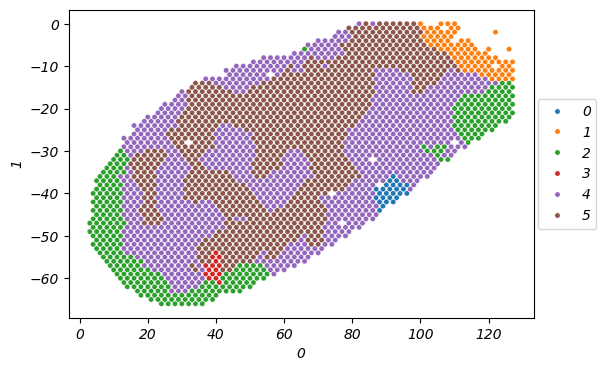

In [25]:
import matplotlib.pyplot as plt
f, axes = plt.subplots(1, 1, figsize=(6, 4))
ax = sns.scatterplot(x=0, y=1, hue = 'GraphBGM-multi',s = 15,  data=df_spatial, palette="tab10")
ax.legend(loc='center right', bbox_to_anchor=(1.15, 0.5), ncol=1)
plt.show()

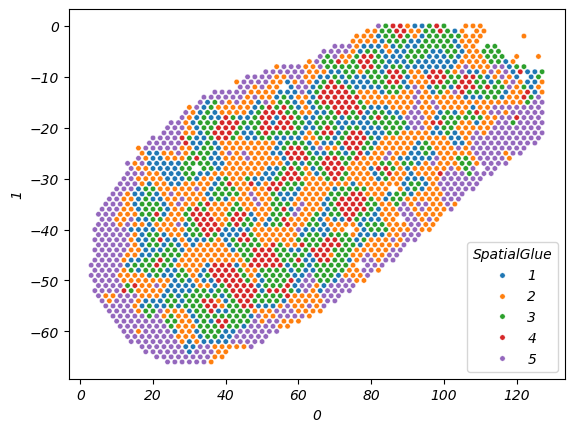

In [26]:
ax = sns.scatterplot(x=0, y=1, hue = 'SpatialGlue',s = 15,  data=df_spatial, palette="tab10")